# Demo notebook: Regrid sea surface temperature data
The data is originally on a tripolar grid to have a smooth grid over the north pole   
We regrid it to Discrete Global Grid System (DGGS) via standard latitude-longitude grid  

## 1. Load required libraries

In [16]:
# Install xarray-healpy and dggs libraries for regridding
%pip install git+https://github.com/IAOCEA/xarray-healpy.git git+https://github.com/xarray-contrib/xdggs.git

  Cloning https://github.com/IAOCEA/xarray-healpy.git to /private/var/folders/_r/k7zwg4td0z54sgjlxsfx325m0000gn/T/pip-req-build-ooya841e
  Running command git clone --filter=blob:none --quiet https://github.com/IAOCEA/xarray-healpy.git /private/var/folders/_r/k7zwg4td0z54sgjlxsfx325m0000gn/T/pip-req-build-ooya841e
  Resolved https://github.com/IAOCEA/xarray-healpy.git to commit 9e42dbeb11afa8b7c5b42982ce256154d11f2e80
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/xarray-contrib/xdggs.git to /private/var/folders/_r/k7zwg4td0z54sgjlxsfx325m0000gn/T/pip-req-build-qqghluxu
  Running command git clone --filter=blob:none --quiet https://github.com/xarray-contrib/xdggs.git /private/var/folders/_r/k7zwg4td0z54sgjlxsfx325m0000gn/T/pip-req-build-qqghluxu
  Resolved https://github.com/xarray-contrib/xdggs.git to commit 9d309eb2e82549f2abe687bf6f9ed3338b1a3d6e
  Installing build de

In [1]:
from pathlib import Path
import numpy as np
import xarray as xr  # N-dimensional arrays with dimension, coordinate and attribute labels
import cartopy.crs as ccrs  # Map projections
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
from data_handling import load_grid_vertex, standardize_variable_names, regrid_to_dggs

warnings.simplefilter("ignore", category=DeprecationWarning)
xr.set_options(display_expand_data=False, display_expand_attrs=False, keep_attrs=True)

## 2. Load sea surface temperature data on tripolar grid

In [2]:
data_path = Path("./CS1-nird/data/")
tripolar_grid_data_path = data_path / "model" / "JRAOC20TRNRPv2_hm_sst_2010-01.nc"
ds = xr.open_dataset(tripolar_grid_data_path)

In [3]:
# Get grid location information
grid_file_path = data_path / "grid" / "grid.nc"
plat, plon, pclat, pclon = load_grid_vertex(grid_file_path)
# latitude and longitude variables, not dimensions
ds = ds.assign_coords(lat=(["y", "x"], plat), lon=(["y", "x"], plon))
ds = standardize_variable_names(ds)
# Center the data
ds.coords["longitude"] = (ds.coords["longitude"] + 180) % 360 - 180
#ds.drop coordinates(["plat", "plon"])
ds

<xarray.Dataset> Size: 14MB
Dimensions:    (time: 1, y: 385, x: 360, nv: 4)
Coordinates:
  * time       (time) object 8B 2010-01-17 00:00:00
    plat       (y, x) float64 1MB ...
    plon       (y, x) float64 1MB ...
    latitude   (y, x) float64 1MB -80.11 -80.11 -80.11 ... 62.59 62.35 62.11
    longitude  (y, x) float64 1MB -109.5 -108.5 -107.5 ... -109.9 -109.9 -110.0
Dimensions without coordinates: y, x, nv
Data variables:
    sst        (time, y, x) float32 554kB ...
    pclat      (y, x, nv) float64 4MB ...
    pclon      (y, x, nv) float64 4MB ...
Attributes: (3)

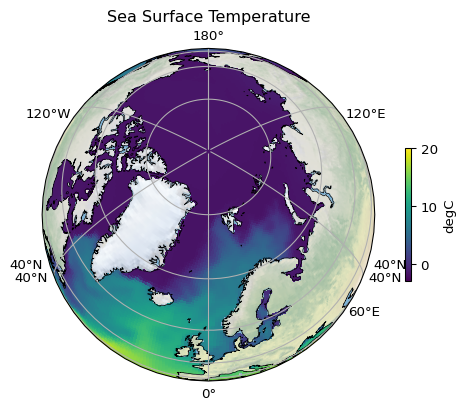

In [4]:
proj = ccrs.NearsidePerspective(
    central_longitude=0.0, central_latitude=80.0, satellite_height=3e6
)
fig, ax = plt.subplots(1, figsize=(8, 4.5), dpi=96, subplot_kw={"projection": proj})

# A temperature map
pm0 = ax.pcolormesh(
    plon,
    plat,
    ds.sst[0, :, :],
    vmin=-3,
    vmax=20,
    cmap="viridis",
    transform=ccrs.PlateCarree(),
    shading="auto",
    rasterized=True,
)


# Add coastlines and the lat-lon grid
ax.coastlines(resolution="50m", color="black", linewidth=0.5)
ax.stock_img()
gl = ax.gridlines(ylocs=range(15, 76, 15), draw_labels=True)
gl.ylocator = mpl.ticker.FixedLocator([40, 50, 60, 70, 80])

plt.colorbar(pm0, fraction=0.2, shrink=0.4, label="degC")

ax.set_title("Sea Surface Temperature")
plt.show()

# 3. Load regridded dataset with PlateCarree grid

In [5]:
bilinear_regridded_data_path = (
    data_path / "model" / "JRAOC20TRNRPv2_hm_sst_2010-01_bil.nc"
)
dr = xr.open_dataset(bilinear_regridded_data_path)

In [6]:
dr = dr.rename_dims({"lat": "latitude", "lon": "longitude"})
dr.latitude.attrs["standard_name"] = "latitude"
dr.longitude.attrs["standard_name"] = "longitude"
dr[["longitude", "latitude"]].compute()
dr = dr.rename({"lon": "longitude", "lat": "latitude"})

/var/folders/_r/k7zwg4td0z54sgjlxsfx325m0000gn/T/ipykernel_1945/1876464242.py:5: UserWarning: rename 'lon' to 'longitude' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  dr = dr.rename({"lon": "longitude", "lat": "latitude"})
/var/folders/_r/k7zwg4td0z54sgjlxsfx325m0000gn/T/ipykernel_1945/1876464242.py:5: UserWarning: rename 'lat' to 'latitude' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  dr = dr.rename({"lon": "longitude", "lat": "latitude"})


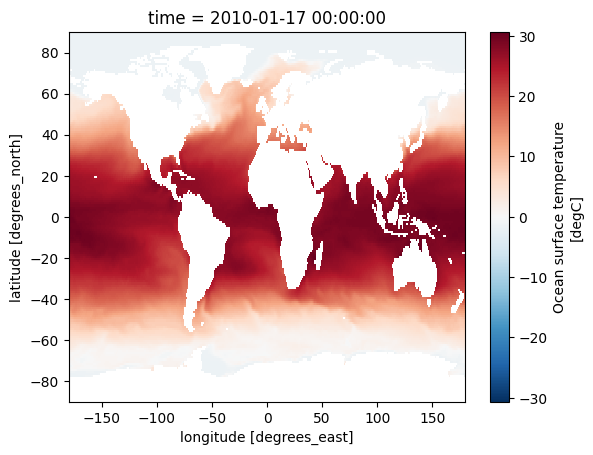

In [7]:
dr.sst.isel(time=0).plot()

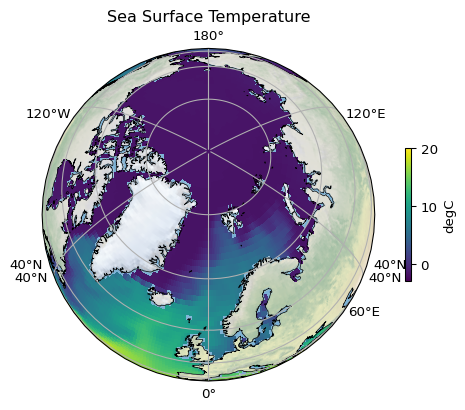

In [8]:
proj = ccrs.NearsidePerspective(
    central_longitude=0.0, central_latitude=80.0, satellite_height=3e6
)
fig, ax = plt.subplots(1, figsize=(8, 4.5), dpi=96, subplot_kw={"projection": proj})

# A temperature map
pm0 = ax.pcolormesh(
    dr.longitude,
    dr.latitude,
    dr.sst[0, :, :],
    vmin=-3,
    vmax=20,
    cmap="viridis",
    transform=ccrs.PlateCarree(),
    shading="auto",
    rasterized=True,
)

# Add coastlines and the lat-lon grid
ax.coastlines(resolution="50m", color="black", linewidth=0.5)
ax.stock_img()
gl = ax.gridlines(ylocs=range(15, 76, 15), draw_labels=True)
gl.ylocator = mpl.ticker.FixedLocator([40, 50, 60, 70, 80])

plt.colorbar(pm0, fraction=0.2, shrink=0.4, label="degC")

ax.set_title("Sea Surface Temperature")
plt.show()

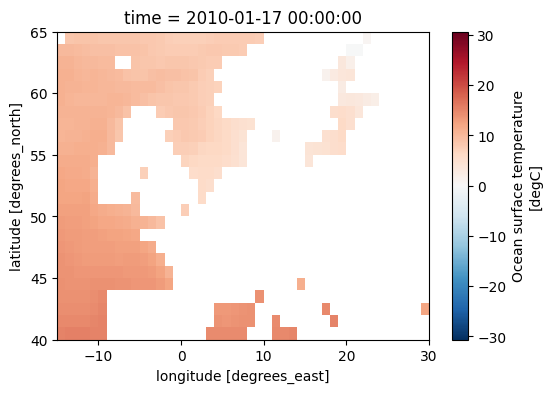

In [9]:
# Have a closer look at a region of interest
lat_min, lat_max = 40, 65
lon_min, lon_max = -15, 30
fig, ax = plt.subplots(figsize=(6, 4))
p = dr.sst.isel(time=0).plot(ax=ax)

# Set zoom limits
ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min, lat_max)

plt.show()

In [10]:
ocean_mask = ~dr.sst.isel(time=0).isnull()  # Mask land as False, ocean as True

# Load conservatively regridded

In [11]:
conservative_regridded_dataset_path = (
    data_path / "model" / "JRAOC20TRNRPv2_hm_sst_2010-01_con.nc"
)
dcon = xr.open_dataset(conservative_regridded_dataset_path)
dcon = dcon.rename_dims({"lat": "latitude", "lon": "longitude"})
dcon.latitude.attrs["standard_name"] = "latitude"
dcon.longitude.attrs["standard_name"] = "longitude"
dcon[["longitude", "latitude"]].compute()
dcon = dcon.rename({"lon": "longitude", "lat": "latitude"})
regrid_diff = dr - dcon

/var/folders/_r/k7zwg4td0z54sgjlxsfx325m0000gn/T/ipykernel_1945/3992794803.py:9: UserWarning: rename 'lon' to 'longitude' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  dcon = dcon.rename({"lon": "longitude", "lat": "latitude"})
/var/folders/_r/k7zwg4td0z54sgjlxsfx325m0000gn/T/ipykernel_1945/3992794803.py:9: UserWarning: rename 'lat' to 'latitude' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  dcon = dcon.rename({"lon": "longitude", "lat": "latitude"})


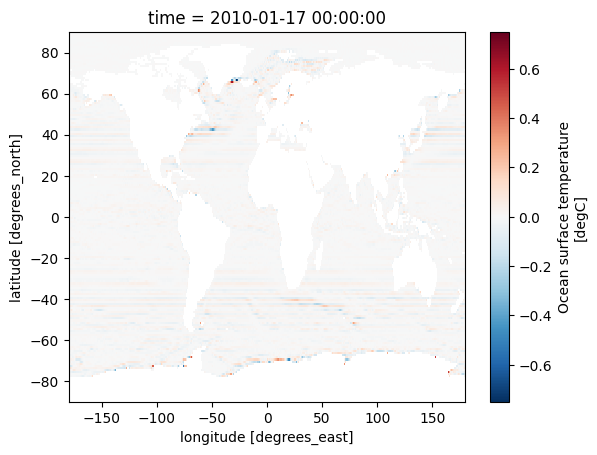

In [12]:
regrid_diff.sst.isel(time=0).plot()

# 4. Regrid from PlateCarree to Healpy DGGS

In [13]:
nside = 256  # Each side of the original 12 faces in Healpix is divided into nside parts
healpy_grid_level = int(np.log2(nside))  # Healpix level
number_of_cells = 12 * nside**2  # The resulting total number of cells

min_vertices = 2  # Minimum number of vertices for a valid transcription for regridding.
# 1 is the most liberal, meaning that only one is needed

print("nside:", nside)
print("Level:", healpy_grid_level)
print("Number of cells:", number_of_cells)

regridded = regrid_to_dggs(
    dcon, nside, min_vertices, method="bilinear", mask=ocean_mask
)
ds_regridded = regridded.sst.compute().squeeze()

nside: 256
Level: 8
Number of cells: 786432


/Users/even/miniforge3/envs/esmpy-env/lib/python3.11/site-packages/xarray_healpy/interpolation/mask.py:22: RuntimeWarning: invalid value encountered in divide
  return masked_weights / np.sum(masked_weights, axis=-1)[:, None]


In [14]:
ds_regridded.dggs.explore()

Map(custom_attribution='', layers=(SolidPolygonLayer(filled=True, get_fill_color=arro3.core.ChunkedArray<Fixed…

# 5. Save the regridded data to zarr

In [15]:
save_location = data_path / f"SST-healpix-lvl-{healpy_grid_level}.zarr"
ds_regridded.to_zarr(save_location, mode="w")

/Users/even/miniforge3/envs/esmpy-env/lib/python3.11/site-packages/zarr/api/asynchronous.py:203: UserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(
